In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import jax
import jax.numpy as jnp
from flax import struct
from gymnax.environments import environment, spaces
from gymnax.wrappers.purerl import GymnaxWrapper
from brax import envs
from brax.envs.wrappers.training import EpisodeWrapper, AutoResetWrapper

class BraxGymnaxWrapper:
    def __init__(self, env_name, backend="positional"):
        env = envs.get_environment(env_name=env_name, backend=backend)
        env = EpisodeWrapper(env, episode_length=1000, action_repeat=1)
        env = AutoResetWrapper(env)
        self._env = env
        self.action_size = env.action_size
        self.observation_size = (env.observation_size,)

    def reset(self, key, params=None):
        state = self._env.reset(key)
        return state.obs, state

    def step(self, key, state, action, params=None):
        next_state = self._env.step(state, action)
        return next_state.obs, next_state, next_state.reward, next_state.done > 0.5, {}

    def observation_space(self, params):
        return spaces.Box(
            low=-jnp.inf,
            high=jnp.inf,
            shape=(self._env.observation_size,),
        )

    def action_space(self, params):
        return spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(self._env.action_size,),
        )

class ClipAction(GymnaxWrapper):
    def __init__(self, env, low=-1.0, high=1.0):
        super().__init__(env)
        self.low = low
        self.high = high

    def step(self, key, state, action, params=None):
        """TODO: In theory the below line should be the way to do this."""
        # action = jnp.clip(action, self.env.action_space.low, self.env.action_space.high)
        action = jnp.clip(action, self.low, self.high)
        return self._env.step(key, state, action, params)

class VecEnv(GymnaxWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.reset = jax.vmap(self._env.reset, in_axes=(0, None))
        self.step = jax.vmap(self._env.step, in_axes=(0, 0, 0, None))

@struct.dataclass
class NormalizeVecObsEnvState:
    mean: jnp.ndarray
    var: jnp.ndarray
    count: float
    env_state: environment.EnvState

class NormalizeVecObservation(GymnaxWrapper):
    def __init__(self, env):
        super().__init__(env)

    def reset(self, key, params=None):
        obs, state = self._env.reset(key, params)
        state = NormalizeVecObsEnvState(
            mean=jnp.zeros_like(obs),
            var=jnp.ones_like(obs),
            count=1e-4,
            env_state=state,
        )
        batch_mean = jnp.mean(obs, axis=0)
        batch_var = jnp.var(obs, axis=0)
        batch_count = obs.shape[0]

        delta = batch_mean - state.mean
        tot_count = state.count + batch_count

        new_mean = state.mean + delta * batch_count / tot_count
        m_a = state.var * state.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + jnp.square(delta) * state.count * batch_count / tot_count
        new_var = M2 / tot_count
        new_count = tot_count

        state = NormalizeVecObsEnvState(
            mean=new_mean,
            var=new_var,
            count=new_count,
            env_state=state.env_state,
        )

        return (obs - state.mean) / jnp.sqrt(state.var + 1e-8), state

    def step(self, key, state, action, params=None):
        obs, env_state, reward, done, info = self._env.step(key, state.env_state, action, params)

        batch_mean = jnp.mean(obs, axis=0)
        batch_var = jnp.var(obs, axis=0)
        batch_count = obs.shape[0]

        delta = batch_mean - state.mean
        tot_count = state.count + batch_count

        new_mean = state.mean + delta * batch_count / tot_count
        m_a = state.var * state.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + jnp.square(delta) * state.count * batch_count / tot_count
        new_var = M2 / tot_count
        new_count = tot_count

        state = NormalizeVecObsEnvState(
            mean=new_mean,
            var=new_var,
            count=new_count,
            env_state=env_state,
        )
        return (obs - state.mean) / jnp.sqrt(state.var + 1e-8), state, reward, done, info


@struct.dataclass
class NormalizeVecRewEnvState:
    mean: jnp.ndarray
    var: jnp.ndarray
    count: float
    return_val: float
    env_state: environment.EnvState

class NormalizeVecReward(GymnaxWrapper):

    def __init__(self, env, gamma):
        super().__init__(env)
        self.gamma = gamma

    def reset(self, key, params=None):
        obs, state = self._env.reset(key, params)
        batch_count = obs.shape[0]
        state = NormalizeVecRewEnvState(
            mean=0.0,
            var=1.0,
            count=1e-4,
            return_val=jnp.zeros((batch_count,)),
            env_state=state,
        )
        return obs, state

    def step(self, key, state, action, params=None):
        obs, env_state, reward, done, info = self._env.step(key, state.env_state, action, params)
        return_val = (state.return_val * self.gamma * (1 - done) + reward)
 
        batch_mean = jnp.mean(return_val, axis=0)
        batch_var = jnp.var(return_val, axis=0)
        batch_count = obs.shape[0]

        delta = batch_mean - state.mean
        tot_count = state.count + batch_count

        new_mean = state.mean + delta * batch_count / tot_count
        m_a = state.var * state.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + jnp.square(delta) * state.count * batch_count / tot_count
        new_var = M2 / tot_count
        new_count = tot_count

        state = NormalizeVecRewEnvState(
            mean=new_mean,
            var=new_var,
            count=new_count,
            return_val=return_val,
            env_state=env_state,
        )
        return obs, state, reward / jnp.sqrt(state.var + 1e-8), done, info

In [3]:
import optax

from reduced_open_es import ReducedOpenES
from evosax import ParameterReshaper, FitnessShaper, NetworkMapper
from evojax.policy import MLPPolicy

from flax.training.train_state import TrainState

def make_train(config):

    env, env_params = BraxGymnaxWrapper(config["ENV_NAME"]), None
    env = ClipAction(env)
    env = VecEnv(env)
    
    def train(commsize, rng):

        # INIT NETWORK
        network = NetworkMapper["MLP"](
            num_hidden_units=128,
            num_hidden_layers=2,
            num_output_units=env.action_size,
            hidden_activation="tanh",
            output_activation="tanh",
        )
        

        pholder = jnp.zeros(env.observation_size)
        params = network.init(
            rng,
            x=pholder,
            rng=rng,
        )

        param_reshaper = ParameterReshaper(params)

        rng, _rng = jax.random.split(rng)
        strategy = ReducedOpenES(popsize=config["POP_SIZE"],
                num_dims=param_reshaper.total_params,
                opt_name="adam",
                lrate_init=config["LR"],
                commsize=commsize,
                horizon_length=config["HORIZON_LENGTH"],
                rng = _rng,
                num_gens=config["NUM_GENERATIONS"])

        fit_shaper = FitnessShaper(centered_rank=True,
                                w_decay=config["W_DECAY"],
                                maximize=True)

        
        def _update_gen(runner_state, unused):
            
            # COLLECT TRAJECTORIES
            def _env_step(carry, unused):
                env_state, last_obs, params, rng, cum_reward = carry

                # SELECT ACTION
                actions = jax.vmap(network.apply)(params, last_obs)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["POP_SIZE"])
                obsv, env_state, reward, done, info = env.step(rng_step, env_state, actions, env_params)
                cum_reward += reward
                # for car in carry:
                #     print(car)
                carry = (env_state, obsv, params, rng, cum_reward)
                return carry, None
            
            def _rollout(rng, params):
                # INIT ENV
                rng, _rng = jax.random.split(rng)
                reset_rng = jax.random.split(_rng, config["POP_SIZE"])
                obsv, env_state = env.reset(reset_rng, env_params)
                carry = (env_state, obsv, params, rng, jnp.zeros((config["POP_SIZE"],)))
                carry, _ = jax.lax.scan(
                    _env_step, carry, None, config["NUM_ENV_STEPS"]
                )
                return carry[-1]

            evo_state, rng = runner_state
            rng, rng_ask = jax.random.split(rng)
            x, evo_state = strategy.ask(rng_ask, evo_state)
            reshaped_params = param_reshaper.reshape(x)
            fitness = _rollout(rng, reshaped_params)
            fit_re = fit_shaper.apply(x, fitness)
            evo_state = strategy.tell(x, fit_re, evo_state)
            runner_state = (evo_state, rng)
            return runner_state, fitness
        
        evo_state = strategy.initialize(rng)
        rng, _rng = jax.random.split(rng)
        runner_state = (evo_state, _rng)
        evo_state, fitness = jax.lax.scan(_update_gen, runner_state, None, config["NUM_GENERATIONS"])
        return evo_state, fitness

    return train

In [4]:
config = {
    "ANNEAL_LR": False,
    "NORMALIZE_ENV": True,
    "MAX_GRAD_NORM": 0.5,
    "ENV_NAME": "ant",
    "NUM_ENV_STEPS": 10,
    "NUM_ROLLOUTS": 1,
    "POP_SIZE": 100,
    "LR": 0.1,
    "NUM_GENERATIONS": 1000,
    "W_DECAY": 0.0,
    "HORIZON_LENGTH":10
}

ms = [25,50,75]#[m for m in range(1,51,1)]
rng = jax.random.PRNGKey(42)
rngs = jax.random.split(rng, 64)
# train=jax.jit(make_train(config))
# outs=train(50,rng)
train_vvjit = jax.jit(
    jax.vmap(
        jax.vmap(
            make_train(config), in_axes=(0, None)
        ), in_axes=(None, 0)
    )
)
outs = train_vvjit(jnp.array(ms),rngs)

ParameterReshaper: 21128 parameters detected for optimization.


-0.88881147


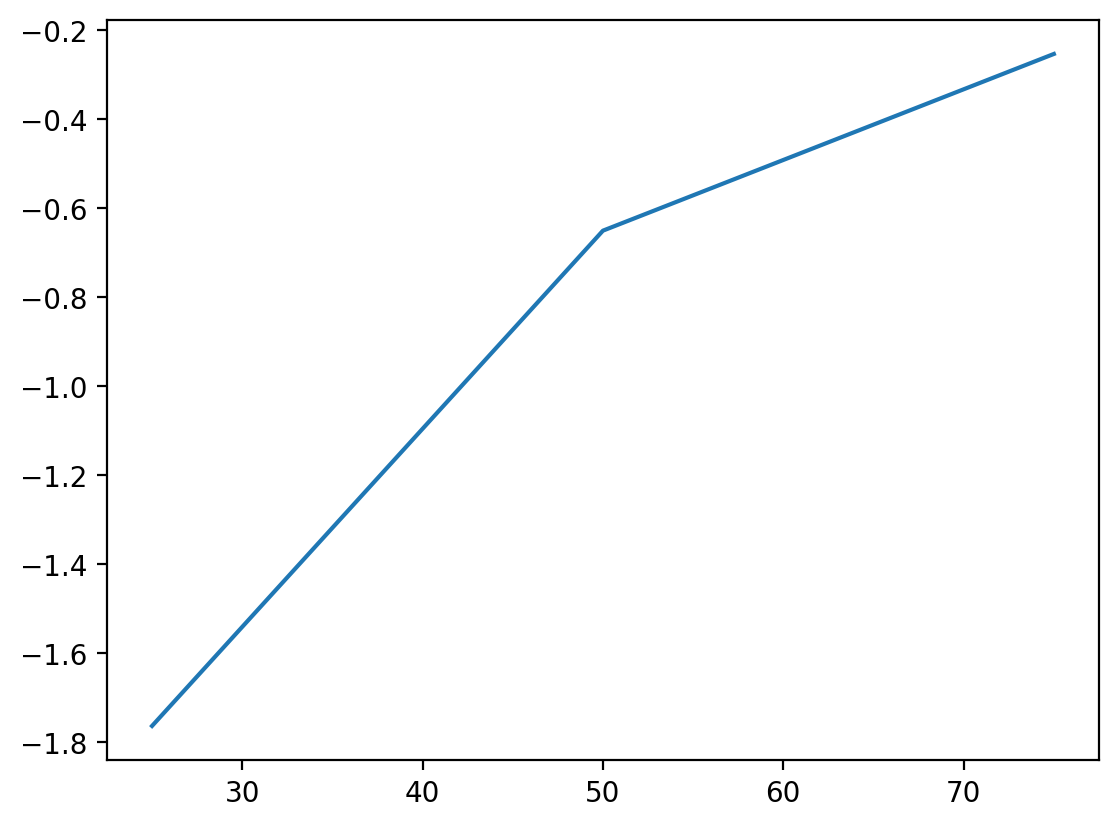

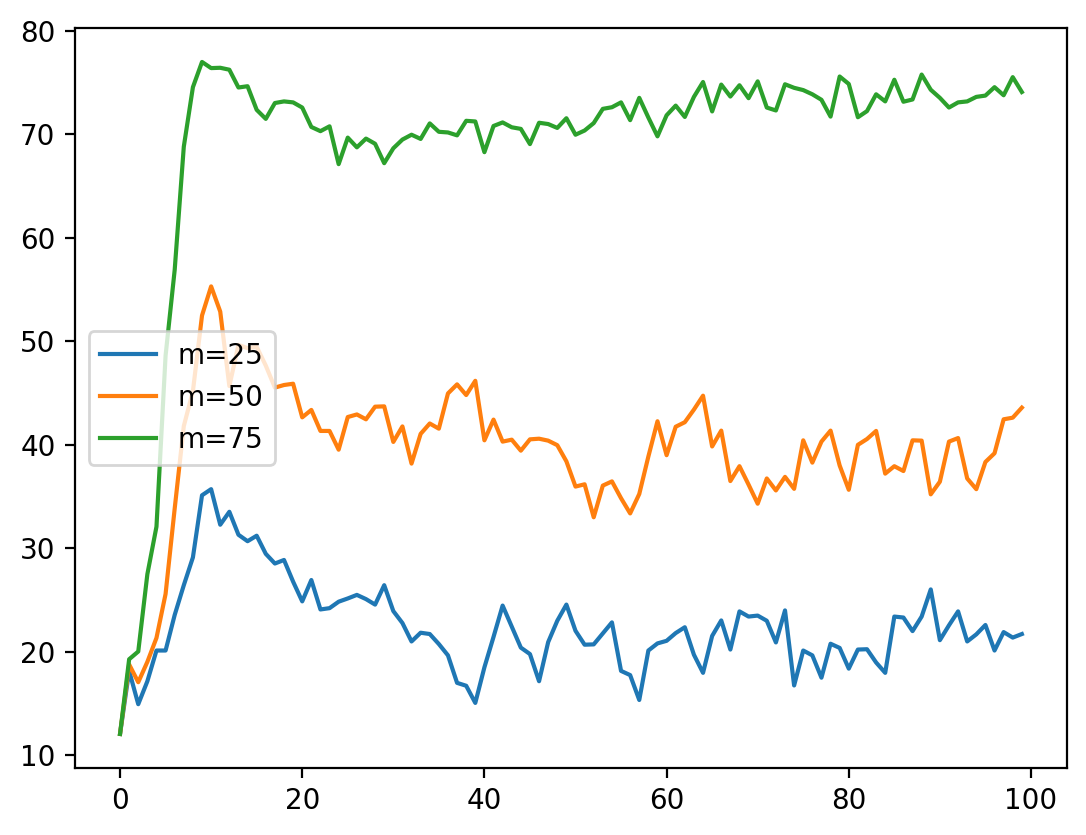

In [ ]:
import matplotlib.pyplot as plt
print(jnp.mean(outs[0][1].mean_err))
plt.plot(ms,jnp.mean(outs[0][1].mean_err, axis=0))
plt.show()
plt.plot(jnp.mean(outs[0][1].num_comms, axis=0).T)
plt.legend(labels=[f"m={m}" for m in ms])
plt.show()

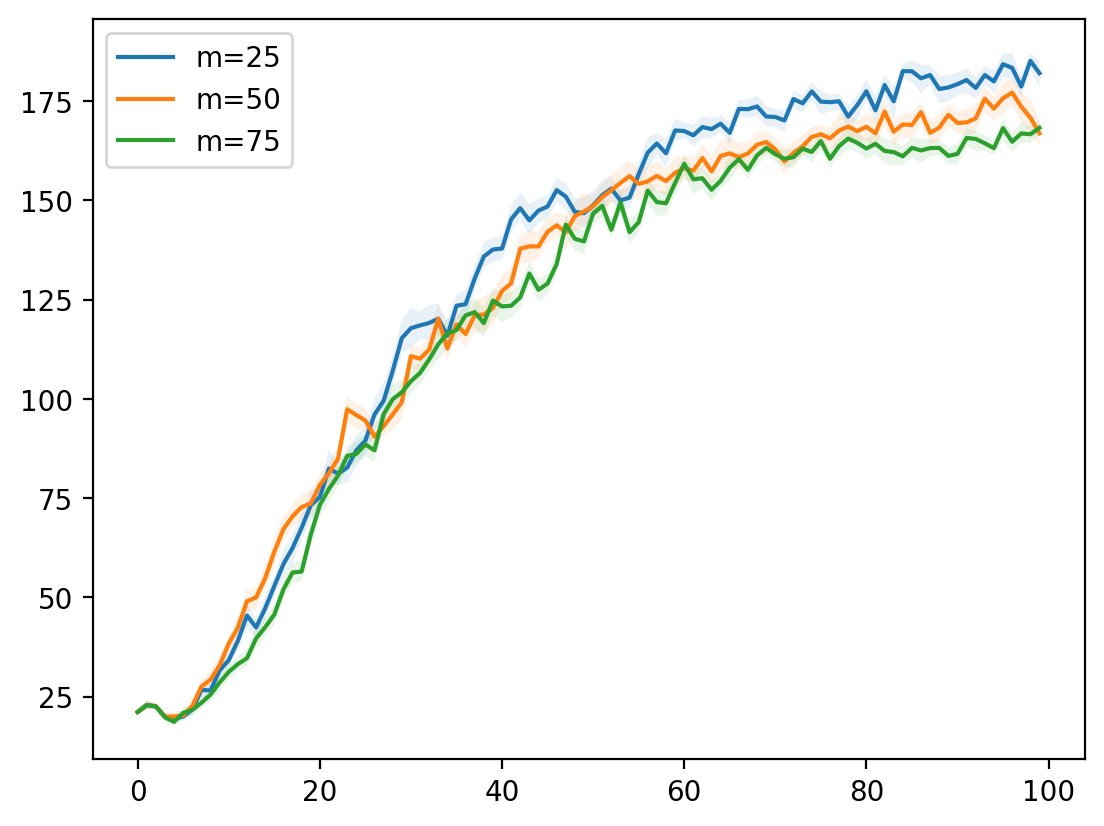

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
agent_means = jnp.mean(outs[1], axis=0)
trial_mean = jnp.mean(agent_means, axis=2)
trial_perc_u = jnp.percentile(agent_means, 10, axis=2)
trial_perc_l = jnp.percentile(agent_means, 90, axis=2)
x = np.arange(config["NUM_GENERATIONS"])
for i,m in enumerate(ms):
    plt.plot(x,trial_mean[i,:], label=f"m={m}")
    plt.fill_between(x, trial_perc_l[i,:], trial_perc_u[i,:], alpha=0.1)
plt.legend()
plt.show()